In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import json
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
import numpy as np

/home/yangze2065/anaconda3/envs/agc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Update this path
rgb_folder = "/home/yangze2065/Documents/autonomous_greenhouse_challenge_2024/dataset/4th_dwarf_tomato/image/train/rgb"

# Update this path
depth_folder = "/home/yangze2065/Documents/autonomous_greenhouse_challenge_2024/dataset/4th_dwarf_tomato/image/train/depth"

# Update this path
json_path = "/home/yangze2065/Documents/autonomous_greenhouse_challenge_2024/dataset/4th_dwarf_tomato/image/train/ground_truth_train.json"

In [2]:
# Filter JSON data to remove entries with missing values and get corresponding image paths
def filter_json_data(json_path, rgb_folder, depth_folder):
    with open(json_path, "r") as f:
        data = json.load(f)
    filtered_data = {
        k: v
        for k, v in data.items()
        if all(
            isinstance(value, (int, float)) and not isinstance(value, bool)
            for value in v.values()
        )
    }

    image_ids = list(filtered_data.keys())
    filtered_image_ids = []
    for image_id in image_ids:
        rgb_path = os.path.exists(os.path.join(rgb_folder, image_id + ".png"))
        depth_path = os.path.exists(os.path.join(depth_folder, image_id + "_depth.png"))
        if rgb_path and depth_path:
            filtered_image_ids.append(image_id)
        else:
            del filtered_data[image_id]
    return filtered_data, filtered_image_ids

In [3]:
# Custom dataset
class TomatoDataset(Dataset):
    def __init__(
        self,
        rgb_folder,
        depth_folder,
        filtered_data,
        filtered_image_ids,
        transform=None,
    ):
        self.rgb_folder = rgb_folder
        self.depth_folder = depth_folder
        self.data = filtered_data
        self.image_ids = filtered_image_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        rgb_path = os.path.join(self.rgb_folder, image_id + ".png")
        depth_path = os.path.join(self.depth_folder, image_id + "_depth.png")

        image = Image.open(rgb_path).convert("RGB")
        depth = Image.open(depth_path).convert("L")

        # Convert single-channel depth image to 3-channel by replicating the depth channel
        depth = Image.merge("RGB", (depth, depth, depth))

        label = self.data[image_id]

        if self.transform:
            image, depth = self.transform(image, depth)

        return image, depth, torch.tensor(list(label.values()), dtype=torch.float32)

In [4]:
# Define transformations with enhanced data augmentation
class PairedTransforms:
    def __init__(self, transforms_rgb, transforms_depth):
        self.transforms_rgb = transforms_rgb
        self.transforms_depth = transforms_depth

    def __call__(self, image, depth):
        # Apply the same transformations to both image and depth
        seed = torch.randint(0, 2**32, (1,)).item()
        torch.manual_seed(seed)
        image = self.transforms_rgb(image)
        torch.manual_seed(seed)
        depth = self.transforms_depth(depth)
        return image, depth


transforms_rgb = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

transforms_depth = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),  # Adjust mean and std for depth
    ]
)

paired_transforms = PairedTransforms(transforms_rgb, transforms_depth)

In [5]:
# Filter the JSON data and get filtered image IDs
filtered_data, filtered_image_ids = filter_json_data(
    json_path, rgb_folder, depth_folder
)

# Load dataset
dataset = TomatoDataset(
    rgb_folder=rgb_folder,
    depth_folder=depth_folder,
    filtered_data=filtered_data,
    filtered_image_ids=filtered_image_ids,
    transform=paired_transforms,
)

In [6]:
# Ensure the dataset is large enough to be split
dataset_size = len(dataset)
if dataset_size < 3:
    raise ValueError(
        f"Dataset too small to be split: {dataset_size} samples available."
    )

In [7]:
# Split dataset
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

# Reduce batch size to handle memory issues
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [8]:
# Define the model
class TomatoNet(nn.Module):
    def __init__(self):
        super(TomatoNet, self).__init__()
        self.resnet_rgb = models.resnet50(pretrained=True)
        self.resnet_rgb.fc = nn.Linear(self.resnet_rgb.fc.in_features, 4)

        self.resnet_depth = models.resnet50(pretrained=True)
        self.resnet_depth.conv1 = nn.Conv2d(
            3, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.resnet_depth.fc = nn.Linear(self.resnet_depth.fc.in_features, 4)

        self.fc_combined = nn.Linear(8, 4)

    def forward(self, x_rgb, x_depth):
        out_rgb = self.resnet_rgb(x_rgb)
        out_depth = self.resnet_depth(x_depth)

        combined = torch.cat((out_rgb, out_depth), dim=1)
        out = self.fc_combined(combined)

        return out

In [ ]:
# Function to compute metrics
def compute_metrics(outputs, labels, threshold=0.5):
    outputs = outputs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    mse = mean_squared_error(labels, outputs)
    mae = mean_absolute_error(labels, outputs)

    # Convert continuous outputs to binary classes
    outputs_bin = (outputs > threshold).astype(int)
    labels_bin = (labels > threshold).astype(int)

    accuracy = accuracy_score(labels_bin, outputs_bin)
    f1 = f1_score(labels_bin, outputs_bin, average="macro")
    precision = precision_score(
        labels_bin, outputs_bin, average="macro", zero_division=0
    )
    recall = recall_score(labels_bin, outputs_bin, average="macro")

    return mse, mae, accuracy, f1, precision, recall

In [9]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = TomatoNet().to(device)

Using device: cuda


/home/yangze2065/anaconda3/envs/agc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yangze2065/anaconda3/envs/agc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/yangze2065/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 66.6MB/s]


In [10]:
# Loss and optimizer
criterion = nn.HuberLoss()
optimizer = optim.AdamW(
    model.parameters(), lr=0.0001, weight_decay=0.01
)  # Adjusted learning rate and added weight decay

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=5, factor=0.5, verbose=True
)

# Early stopping
early_stopping_patience = 10
best_val_loss = float("inf")
early_stopping_counter = 0

# Lists to store loss values and metrics
train_losses = []
val_losses = []
train_metrics = []
val_metrics = []

In [12]:
# Training loop with mixed precision
scaler = torch.cuda.amp.GradScaler()

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_mse, train_mae, train_accuracy, train_f1, train_precision, train_recall = (
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
    )
    for i, (images, depths, labels) in enumerate(train_loader):
        images, depths, labels = images.to(device), depths.to(device), labels.to(device)

        # Forward pass with mixed precision
        with torch.cuda.amp.autocast():
            outputs = model(images, depths)
            loss = criterion(outputs, labels)

        # Check for NaN values
        if torch.isnan(loss).any():
            print(f"NaN loss encountered at epoch {epoch+1}, batch {i+1}")
            continue

        # Backward and optimize
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # Compute metrics
        (
            batch_mse,
            batch_mae,
            batch_accuracy,
            batch_f1,
            batch_precision,
            batch_recall,
        ) = compute_metrics(outputs, labels)
        train_mse += batch_mse
        train_mae += batch_mae
        train_accuracy += batch_accuracy
        train_f1 += batch_f1
        train_precision += batch_precision
        train_recall += batch_recall

    epoch_loss = running_loss / len(train_loader)
    train_mse /= len(train_loader)
    train_mae /= len(train_loader)
    train_accuracy /= len(train_loader)
    train_f1 /= len(train_loader)
    train_precision /= len(train_loader)
    train_recall /= len(train_loader)
    train_losses.append(epoch_loss)
    train_metrics.append(
        (train_mse, train_mae, train_accuracy, train_f1, train_precision, train_recall)
    )
    print(
        f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}"
    )

    # Validation
    model.eval()
    val_loss = 0.0
    val_mse, val_mae, val_accuracy, val_f1, val_precision, val_recall = (
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
    )
    with torch.no_grad():
        for images, depths, labels in val_loader:
            images, depths, labels = (
                images.to(device),
                depths.to(device),
                labels.to(device),
            )

            outputs = model(images, depths)
            loss = criterion(outputs, labels)

            # Check for NaN values
            if torch.isnan(loss).any():
                print(f"NaN loss encountered at epoch {epoch+1}, validation batch")
                continue

            val_loss += loss.item()

            # Compute metrics
            (
                batch_mse,
                batch_mae,
                batch_accuracy,
                batch_f1,
                batch_precision,
                batch_recall,
            ) = compute_metrics(outputs, labels)
            val_mse += batch_mse
            val_mae += batch_mae
            val_accuracy += batch_accuracy
            val_f1 += batch_f1
            val_precision += batch_precision
            val_recall += batch_recall

    val_loss /= len(val_loader)
    val_mse /= len(val_loader)
    val_mae /= len(val_loader)
    val_accuracy /= len(val_loader)
    val_f1 /= len(val_loader)
    val_precision /= len(val_loader)
    val_recall /= len(val_loader)
    val_losses.append(val_loss)
    val_metrics.append(
        (val_mse, val_mae, val_accuracy, val_f1, val_precision, val_recall)
    )
    print(
        f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, MSE: {val_mse:.4f}, MAE: {val_mae:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}"
    )

    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

NaN loss encountered at epoch 1, batch 6
NaN loss encountered at epoch 1, batch 7
Epoch [1/50], Training Loss: 233.2553
Epoch [1/50], Validation Loss: 291.8615
NaN loss encountered at epoch 2, batch 3
NaN loss encountered at epoch 2, batch 5


/home/yangze2065/anaconda3/envs/agc/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [2/50], Training Loss: 226.0131
Epoch [2/50], Validation Loss: 291.2613
NaN loss encountered at epoch 3, batch 1
NaN loss encountered at epoch 3, batch 4
Epoch [3/50], Training Loss: 238.3404
Epoch [3/50], Validation Loss: 290.4514
NaN loss encountered at epoch 4, batch 2
Epoch [4/50], Training Loss: 281.1429
Epoch [4/50], Validation Loss: 289.3294
NaN loss encountered at epoch 5, batch 3
NaN loss encountered at epoch 5, batch 4
Epoch [5/50], Training Loss: 215.9322
Epoch [5/50], Validation Loss: 288.5508
NaN loss encountered at epoch 6, batch 2
NaN loss encountered at epoch 6, batch 6
Epoch [6/50], Training Loss: 241.9598
Epoch [6/50], Validation Loss: 287.7742
NaN loss encountered at epoch 7, batch 6
Epoch [7/50], Training Loss: 279.5800
Epoch [7/50], Validation Loss: 286.6520
NaN loss encountered at epoch 8, batch 2
NaN loss encountered at epoch 8, batch 6
Epoch [8/50], Training Loss: 226.5704
Epoch [8/50], Validation Loss: 285.9367
NaN loss encountered at epoch 9, batch 3
NaN

In [ ]:
# Save the model and its weights
torch.save(model.state_dict(), "tomato_model.pth")
print("Model saved to tomato_model.pth")

In [ ]:
# Evaluation
model.eval()
test_loss = 0.0
test_mse, test_mae, test_accuracy, test_f1, test_precision, test_recall = (
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
)
with torch.no_grad():
    for images, depths, labels in test_loader:
        images, depths, labels = images.to(device), depths.to(device), labels.to(device)

        outputs = model(images, depths)
        loss = criterion(outputs, labels)

        # Check for NaN values
        if torch.isnan(loss).any():
            print("NaN loss encountered in test set")
            continue

        test_loss += loss.item()

        # Compute metrics
        (
            batch_mse,
            batch_mae,
            batch_accuracy,
            batch_f1,
            batch_precision,
            batch_recall,
        ) = compute_metrics(outputs, labels)
        test_mse += batch_mse
        test_mae += batch_mae
        test_accuracy += batch_accuracy
        test_f1 += batch_f1
        test_precision += batch_precision
        test_recall += batch_recall

test_loss /= len(test_loader)
test_mse /= len(test_loader)
test_mae /= len(test_loader)
test_accuracy /= len(test_loader)
test_f1 /= len(test_loader)
test_precision /= len(test_loader)
test_recall /= len(test_loader)
print(
    f"Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}"
)

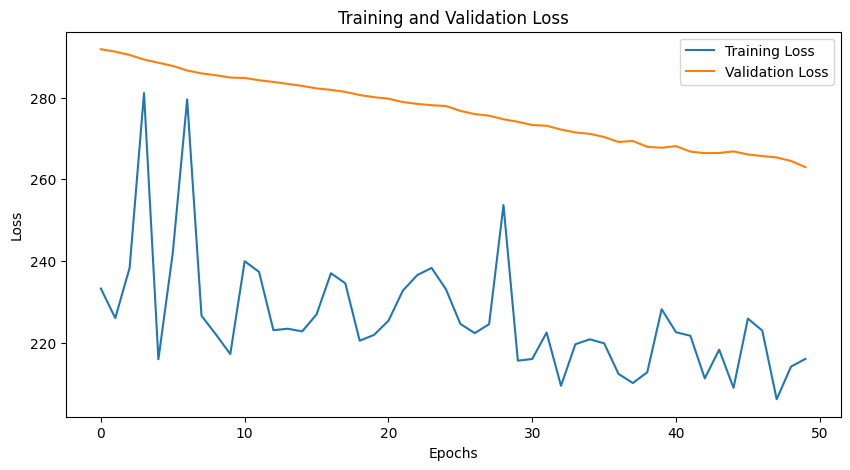

In [13]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# Plotting the training and validation metrics
(
    train_mse_values,
    train_mae_values,
    train_accuracy_values,
    train_f1_values,
    train_precision_values,
    train_recall_values,
) = zip(*train_metrics)
(
    val_mse_values,
    val_mae_values,
    val_accuracy_values,
    val_f1_values,
    val_precision_values,
    val_recall_values,
) = zip(*val_metrics)

plt.figure(figsize=(10, 5))
plt.plot(train_mse_values, label="Training MSE")
plt.plot(val_mse_values, label="Validation MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.title("Training and Validation MSE")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_mae_values, label="Training MAE")
plt.plot(val_mae_values, label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.title("Training and Validation MAE")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_values, label="Training Accuracy")
plt.plot(val_accuracy_values, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_f1_values, label="Training F1")
plt.plot(val_f1_values, label="Validation F1")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.title("Training and Validation F1 Score")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_precision_values, label="Training Precision")
plt.plot(val_precision_values, label="Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()
plt.title("Training and Validation Precision")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_recall_values, label="Training Recall")
plt.plot(val_recall_values, label="Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.title("Training and Validation Recall")
plt.show()

In [14]:
# Evaluation
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        # Check for NaN values
        if torch.isnan(loss).any():
            print("NaN loss encountered in test set")
            continue

        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 233.3611


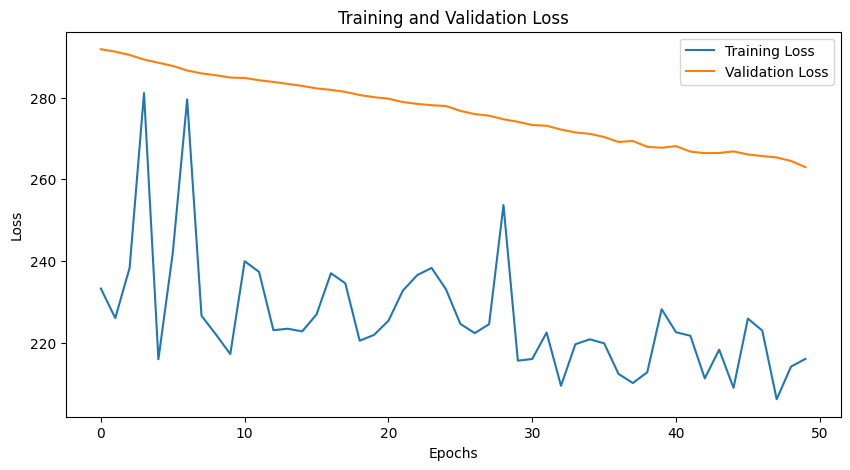

In [15]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()